# CUIDADO!

No correr todo el archivo ya que contiene el grid search

In [4]:
# Obtenemos las variables de entorno

import os
from dotenv import load_dotenv

PATH = os.getcwd()
PATH = PATH.replace("/Price", "")

load_dotenv(PATH + "/.env")

True

In [5]:
import urllib.parse
import certifi
from pymongo.mongo_client import MongoClient
import json
import pandas as pd
import os

pd.set_option('display.max_columns', None)

username = urllib.parse.quote_plus(os.getenv("MONGO_USERNAME"))
password = urllib.parse.quote_plus(os.getenv("MONGO_PASSWORD"))

uri = "mongodb://{}:{}@{}:{}/?authSource={}&authMechanism={}".format(username, password, os.getenv("MONGO_HOST"),
                                            os.getenv("MONGO_PORT"), os.getenv("MONGO_DATABASE"), "SCRAM-SHA-1")

client = MongoClient(uri)

In [6]:
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [8]:
db = client[os.getenv("MONGO_DATABASE")]
collection = db.PriceProduction

# Debido a que el tipo de operación esta embebido en el campo "attributes" vamos a tener
# que importar todo y filtrar luego

properties = collection.find({})

In [9]:
properties_list = list()

for p in properties:
    properties_list.append(p)

In [11]:
print(len(properties_list))
df = pd.DataFrame(properties_list)
df.drop(["_id"], axis=1, inplace=True)

6701


In [13]:
pd.set_option('display.max_columns', None)

<Axes: xlabel='surface_total', ylabel='price'>

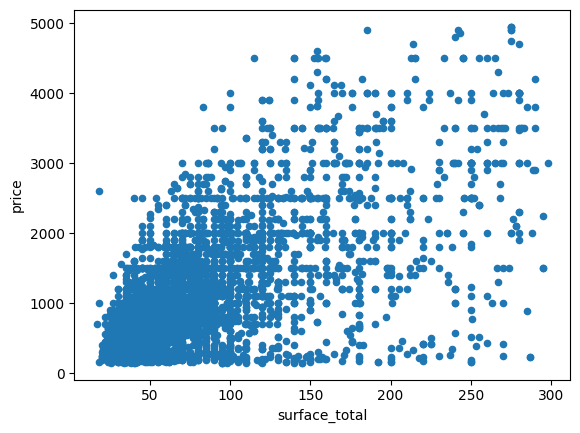

In [28]:
from sklearn.metrics import mean_squared_error

# Tenemos varios outliers en relación a superficie de los departamentos

df = df.loc[df.price > 150]
df = df.loc[df.price < 5000]
df = df.loc[df.surface_total > 15]
df = df.loc[df.surface_total < 300]

# Precio por superficie
var = 'surface_total'
data = pd.concat([df['price'], df[var]], axis=1)
data.plot.scatter(x=var, y='price')

In [29]:
df.price.describe()
df = df.loc[df.antiquity.notna()]

In [30]:
from sklearn.model_selection import train_test_split
y = df.price
X = df.drop(["price"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Linear Regression

Se realizará un grid search sobre la regresión lineal para validar qué modelo mejor se aproxima

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

linear_regression = LinearRegression()
linear_regression_grid = dict()
linear_regression_grid['fit_intercept'] = [True, False]
linear_regression_grid['positive'] = [True, False]

# Definimos el procedimiento de grid search
linear_regression_grid_search = GridSearchCV(estimator=linear_regression, param_grid=linear_regression_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
linear_regression_grid_result = linear_regression_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (linear_regression_grid_result.best_score_, linear_regression_grid_result.best_params_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best: 0.500274 using {'fit_intercept': False, 'positive': True}


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


best_linear_regression = LinearRegression(fit_intercept=False, positive=True)
best_linear_regression_model = best_linear_regression.fit(X_train, y_train)

best_linear_regression_pred = best_linear_regression_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_linear_regression_pred, squared=False)))
print("Model score is: " + str(best_linear_regression_model.score(X_test, y_test)))

RMSE score is: 1112.4783115075802
Model score is: 0.5687404967104792


# Lasso Regression
Se realizará un grid search sobre la regresión Lasso para verificar los mejores resultados

In [7]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso_regression = Lasso()
lasso_regression_grid = dict()
lasso_regression_grid['alpha'] = [0.0005, 0.005, 0.02, 0.03]

# Definimos el procedimiento de grid search
lasso_regression_grid_search = GridSearchCV(estimator=lasso_regression, param_grid=lasso_regression_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
lasso_regression_grid_result = lasso_regression_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (lasso_regression_grid_result.best_score_, lasso_regression_grid_result.best_params_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best: 0.498232 using {'alpha': 0.03}


C:\Users\Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e+07, tolerance: 5.084e+05
  model = cd_fast.enet_coordinate_descent(


In [6]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error


best_lasso_regression = Lasso(alpha=0.03)
best_lasso_regression_model = best_lasso_regression.fit(X_train, y_train)

best_lasso_regression_pred = best_lasso_regression_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_lasso_regression_pred, squared=False)))
print("Model score is: " + str(best_lasso_regression_model.score(X_test, y_test)))

RMSE score is: 1093.3236990030948
Model score is: 0.5834634682140611


C:\Users\Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.008e+06, tolerance: 3.173e+05
  model = cd_fast.enet_coordinate_descent(


# Elastic Net regression
Realizaremos un grid search sobre los parámetros de elastic net para buscar el mejor resultado.

In [9]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

enet_regression = ElasticNet()
enet_regression_grid = dict()
enet_regression_grid['alpha'] = [0.0005, 0.005, 0.02, 0.03]
enet_regression_grid['l1_ratio'] = [0.01, 0.001, 0.1, 0.5]

# Definimos el procedimiento de grid search
enet_regression_grid_search = GridSearchCV(estimator=enet_regression, param_grid=enet_regression_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
enet_regression_grid_result = enet_regression_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (enet_regression_grid_result.best_score_, enet_regression_grid_result.best_params_))

Fitting 2 folds for each of 16 candidates, totalling 32 fits
Best: 0.508122 using {'alpha': 0.02, 'l1_ratio': 0.5}


In [7]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error


best_enet_regression = ElasticNet(alpha=0.02, l1_ratio=.5, random_state=3)
best_enet_regression_model = best_enet_regression.fit(X_train, y_train)

best_enet_regression_pred = best_enet_regression_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_enet_regression_pred, squared=False)))
print("Model score is: " + str(best_enet_regression_model.score(X_test, y_test)))

RMSE score is: 1093.7154797425274
Model score is: 0.5831648919928796


# Kernel Ridge
Se realizará un grid search para revisar los mejores hiperparámetros para utilizar con Kernel Ridge

In [11]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

krr = KernelRidge()
krr_grid = dict()
krr_grid['alpha'] = [0.0005, 0.005, 0.02, 0.03]
krr_grid['degree'] = [1, 2, 6]
krr_grid['coef0'] = [0.1, 1, 2.5]
krr_grid['kernel'] = ['linear', 'polynomial']


# Definimos el procedimiento de grid search
krr_grid_search = GridSearchCV(estimator=krr, param_grid=krr_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
krr_grid_result = krr_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (krr_grid_result.best_score_, krr_grid_result.best_params_))

Fitting 2 folds for each of 72 candidates, totalling 144 fits
Best: 0.558142 using {'alpha': 0.03, 'coef0': 1, 'degree': 2, 'kernel': 'polynomial'}


In [8]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error


best_krr = KernelRidge(alpha=0.03, kernel='polynomial', degree=2, coef0=1)
best_krr_model = best_krr.fit(X_train, y_train)

best_krr_pred = best_krr_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_krr_pred, squared=False)))
print("Model score is: " + str(best_krr_model.score(X_test, y_test)))

RMSE score is: 1074.3868977240022
Model score is: 0.5977676656195268


# Random Forest
Busqueda de mejores hiperparámetros para utilización de Random Forest.

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()
rf_grid = dict()
rf_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['squared_error', 'absolute_error', 'poisson']
}


# Definimos el procedimiento de grid search
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
rf_grid_result = rf_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))

Fitting 2 folds for each of 486 candidates, totalling 972 fits
Best: 0.565351 using {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


best_rf = RandomForestRegressor(criterion="squared_error", max_depth=20, max_features="sqrt", min_samples_leaf = 1, min_samples_split = 10, n_estimators = 300)
best_rf_model = best_rf.fit(X_train, y_train)

best_rf_pred = best_rf_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_rf_pred, squared=False)))
print("Model score is: " + str(best_rf_model.score(X_test, y_test)))

RMSE score is: 1058.8435546614983
Model score is: 0.6093218097261586


# Bagging Regressor

Busqueda de hiperparametros para Bagging Regressor

In [20]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV

bagging = BaggingRegressor()
bagging_grid = dict()
bagging_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 0.9],
    'max_features': [0.5, 0.7, 0.9]
}


# Definimos el procedimiento de grid search
bagging_grid_search = GridSearchCV(estimator=bagging, param_grid=bagging_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
bagging_grid_result = bagging_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (bagging_grid_result.best_score_, bagging_grid_result.best_params_))

Fitting 2 folds for each of 27 candidates, totalling 54 fits
Best: 0.541222 using {'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 100}


In [11]:
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error


best_bagging = BaggingRegressor(max_features = 0.7, max_samples = 0.5, n_estimators= 100)
best_bagging_model = best_bagging.fit(X_train, y_train)

best_bagging_pred = best_bagging_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_bagging_pred, squared=False)))
print("Model score is: " + str(best_bagging_model.score(X_test, y_test)))

RMSE score is: 1109.6827192742114
Model score is: 0.5709052326382318


# Ada Boost Regressor
Busqueda de mejores hiperparámetros para modelo Ada Boost

In [23]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

ada = AdaBoostRegressor()
ada_grid = dict()
ada_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.001, 0.1],
}


# Definimos el procedimiento de grid search
ada_grid_search = GridSearchCV(estimator=ada, param_grid=ada_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
ada_grid_result = ada_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (ada_grid_result.best_score_, ada_grid_result.best_params_))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Best: 0.516795 using {'learning_rate': 0.1, 'n_estimators': 50}


In [12]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error


best_ada = AdaBoostRegressor(learning_rate=0.1, n_estimators=50, loss="square")
best_ada_model = best_ada.fit(X_train, y_train)

best_ada_pred = best_ada_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_ada_pred, squared=False)))
print("Model score is: " + str(best_ada_model.score(X_test, y_test)))

RMSE score is: 1111.2740640848986
Model score is: 0.5696736601670833


# SVM
Busqueda de hiperparámetros para mejor aproximación con SVM (SVR para regresión)

In [25]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr = SVR()
svr_grid = dict()
svr_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']    
}


# Definimos el procedimiento de grid search
svr_grid_search = GridSearchCV(estimator=svr, param_grid=svr_grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
svr_grid_result = svr_grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (svr_grid_result.best_score_, svr_grid_result.best_params_))

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best: 0.469146 using {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


In [13]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error


best_svr = SVR(C=10, gamma='scale', kernel='linear')
best_svr_model = best_svr.fit(X_train, y_train)

best_svr_pred = best_svr_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, best_svr_pred, squared=False)))
print("Model score is: " + str(best_svr_model.score(X_test, y_test)))

RMSE score is: 1109.4098146059475
Model score is: 0.5711162615452209


# Gradient Booster Regressor
Busqueda de mejores hiperparametos para Gradient Boosting

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

model = GradientBoostingRegressor()
grid = dict()
grid['random_state'] = [5]

grid['loss'] = ["squared_error", "absolute_error", "huber", "quantile"]
#grid['loss'] = ["absolute_error"]

grid['max_features'] = ["sqrt", "log2"]
#grid['max_features'] = ["sqrt"]

grid['n_estimators'] = [500, 1000, 3000, 5000]
#grid['n_estimators'] = [3000]

grid['min_samples_split'] = [2, 5, 7, 10, 15]
#grid['min_samples_split'] = [10]

grid['min_samples_leaf'] = [2, 5, 7, 10, 15]
#grid['min_samples_leaf'] = [15]

grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.05, 0.1]
#grid['learning_rate'] = [0.05]

grid['subsample'] = [0.5, 0.7, 1.0]
#grid['subsample'] = [1]

grid['max_depth'] = [3, 5, 7, 9]
#grid['max_depth'] = [4]


# Procedimiento de evaluación, utilizamos RepeatedKFold
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Definimos el procedimiento de grid search
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, verbose=2, cv=2)

# Ejecutamos el grid search
grid_result = grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 2 folds for each of 48000 candidates, totalling 96000 fits
Best: 0.578083 using {'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1000, 'random_state': 5, 'subsample': 0.5}


In [31]:
from sklearn.ensemble import GradientBoostingRegressor

# Con hiperparámetros probados

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state = 15)
GBoost_model = GBoost.fit(X_train, y_train)

GBoost_pred = GBoost_model.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, GBoost_pred, squared=False)))
print("Model score is: " + str(GBoost_model.score(X_test, y_test)))

RMSE score is: 500.76235811123576
Model score is: 0.6193697053629992


In [32]:
from sklearn.ensemble import GradientBoostingRegressor

# Con resultados del CVGridSearch

GBoost2 = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=2, min_samples_split=15,
                                   loss='absolute_error', random_state = 5, subsample=0.5)
GBoost_model2 = GBoost2.fit(X_train, y_train)

GBoost_pred2 = GBoost_model2.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, GBoost_pred2, squared=False)))
print("Model score is: " + str(GBoost_model2.score(X_test, y_test)))

RMSE score is: 490.5554292199989
Model score is: 0.634728176553561


In [33]:
from sklearn.ensemble import GradientBoostingRegressor

# Con resultados del CVGridSearch grande

GBoost2 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01,
                                   max_depth=9, max_features='log2',
                                   min_samples_leaf=2, min_samples_split=5,
                                   loss='squared_error', random_state = 5, subsample=0.5)
GBoost_model2 = GBoost2.fit(X_train, y_train)

GBoost_pred2 = GBoost_model2.predict(X_test)
print("RMSE score is: " + str(mean_squared_error(y_test, GBoost_pred2, squared=False)))
print("Model score is: " + str(GBoost_model2.score(X_test, y_test)))

RMSE score is: 484.37352275780927
Model score is: 0.6438763711993984


In [34]:
# Vamos a persistir el modelo que mejor nos dió

import pickle
from joblib import dump, load

dump(GBoost_model2, 'Models/gboost_modelv2_1.joblib')

['Models/gboost_modelv2_1.joblib']

In [11]:
columns_list = X_test.columns.tolist()
print(columns_list)

['characteristincs_balcony', 'characteristincs_yard', 'characteristincs_rooftop', 'characteristincs_garage', 'amenities_amoblado', 'amenities_cancha_paddle', 'amenities_cancha_tenis', 'amenities_gimnasio', 'amenities_hidromasaje', 'amenities_laundry', 'amenities_microcine', 'amenities_parrilla', 'amenities_piscina', 'amenities_sala_de_juegos', 'amenities_sauna', 'amenities_solarium', 'amenities_spa', 'amenities_sum', 'amenities_estacionamiento_visitas', 'antiquity', 'ambience', 'bedrooms', 'bathrooms', 'surface_total', 'centros_comerciales_cercanos', 'parques_cercanos', 'escuelas_cercanas', 'location_neighbourhood_Abasto', 'location_neighbourhood_Agronomía', 'location_neighbourhood_Almagro', 'location_neighbourhood_Almagro Norte', 'location_neighbourhood_Almagro Sur', 'location_neighbourhood_Balvanera', 'location_neighbourhood_Congreso', 'location_neighbourhood_Once', 'location_neighbourhood_Barracas', 'location_neighbourhood_Barrio Norte', 'location_neighbourhood_La isla', 'location_n